In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Corpus Classification")

In [5]:
df = pd.read_csv(os.getcwd()+r"\Data Files\Corpus_MRO.csv", encoding = 'unicode_escape')

In [85]:
df.head()

,spend_group,spend_cat_sim_l1_nestec,spend_cat_sim_l2_nestec,spend_cat_sim_l3_nestec,material_group_master_data,material_group_master_data_desc,material,material_desc,material_descr_from_po,purchasing_org,...,material_type,material_type_desc,base_unit,account_number,account_number_desc,cost_center,cost_center_desc,invoice_amount,invoice_amt_rep_curr_mth_rate,label_l2
0,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,** Carbagas/Kohlendioxyd CO2 Flüssiggas,CH10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5012160,Energy-CO2,0010/001718102,CO2,"10,400.42 CHF","10,400.42",24 Industrial Gases
1,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,***UMO ALQUILER UNIDAD CRIOGENICA,ES10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5046000,Operating Supplies,0045/794241001,Gastos comunes fábri,"3,574.48 EUR","3,972.83",24 Industrial Gases
2,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,"**19 - CARBON DIOXIDE, COMPLIANCE TRANSP",US10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5046000,Operating Supplies,0076/013893010,Site Supply Chain,"$15,822.53","15,657.73",24 Industrial Gases
3,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,**Bulk CO2 Gas,US10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5014020,Eng. 3rd Part Serv,0042/548919003,TECHNICAL OFFICE,"$1,726.96","1,698.81",24 Industrial Gases
4,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,**CO2 - BULK CARBON DIOXIDE,US10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5046000,Operating Supplies,0042/587817201,REFRIGERATION,"$8,786.90","8,777.23",24 Industrial Gases


In [86]:
x_column = ["material_descr_from_po","vendor_desc","account_number_desc","cost_center_desc"]
y_column = ["label_l2"]
seed = 10

In [87]:
df.label_l2.value_counts()

24 MRO Services                   3566
24 Workshop Equipment&Supplies    1121
24 Industrial Gases                669
Name: label_l2, dtype: int64

In [88]:
X_train_1, X_test, y_train_1, y_test = train_test_split(df[x_column], df[y_column], test_size=0.2, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=seed)

In [89]:
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)
X_valid.reset_index(inplace = True)


In [90]:
print("Train sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_train.shape[0],
                                 round((y_train=="24 MRO Services").sum()/y_train.count()*100,2),
                                 round((y_train=="24 Workshop Equipment&Supplies").sum()/y_train.count()*100,2),
                                 round((y_train=="24 Industrial Gases").sum()/y_train.count()*100,2))
     )

print("valid sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_valid.shape[0],
                                 round((y_valid=="24 MRO Services").sum()/y_valid.count()*100,2),
                                 round((y_valid=="24 Workshop Equipment&Supplies").sum()/y_valid.count()*100,2),
                                 round((y_valid=="24 Industrial Gases").sum()/y_valid.count()*100,2))
     )

print("test sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_test.shape[0],
                                 round((y_test=="24 MRO Services").sum()/y_test.count()*100,2),
                                 round((y_test=="24 Workshop Equipment&Supplies").sum()/y_test.count()*100,2),
                                 round((y_test=="24 Industrial Gases").sum()/y_test.count()*100,2))
     )

Train sample : 3427 	 24 MRO Services : 66.9 	 24 Workshop Equipment&Supplies : 20.8 	Industrial Gases : 12.3
valid sample : 857 	 24 MRO Services : 64.8 	 24 Workshop Equipment&Supplies : 21.6 	Industrial Gases : 13.7
test sample : 1072 	 24 MRO Services : 67.0 	 24 Workshop Equipment&Supplies : 21.0 	Industrial Gases : 12.0


In [91]:
from sklearn.feature_extraction.text import CountVectorizer

for selected_col in x_column:
    sentences_train = X_train[selected_col].values
    sentences_valid = X_valid[selected_col].values
    sentences_test = X_test[selected_col].values

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)

    X_train = X_train.merge(pd.DataFrame(vectorizer.transform(sentences_train).toarray()),left_index=True, right_index = True)
    X_valid = X_valid.merge(pd.DataFrame(vectorizer.transform(sentences_valid).toarray()),left_index=True, right_index = True)
    X_test  = X_test.merge(pd.DataFrame(vectorizer.transform(sentences_test).toarray()),left_index=True, right_index = True)

In [92]:
all_col = list(X_train.columns)

In [93]:
all_col.remove('index')
all_col.remove('material_descr_from_po')
all_col.remove('vendor_desc')
all_col.remove('account_number_desc')
all_col.remove('cost_center_desc')

## Logistic Model

## L2 Penalty Hyper Parameter Optimization

In [94]:
param_grid = {'C':np.exp(np.arange(-2,1,0.01))}

In [95]:
from sklearn.model_selection import StratifiedKFold
kfolds = StratifiedKFold(3, random_state=1)
comb=LogisticRegression(penalty = 'l2')

rcv = RandomizedSearchCV(estimator = comb, param_distributions=param_grid, scoring=['accuracy'], n_iter = 50,
    cv=kfolds.split(X_train[all_col],y_train), verbose=0, random_state=1,
    refit = 'accuracy', return_train_score=True, error_score = 0)

In [96]:
#Calculate Gini Lift Logistic Regression
print("Randomized search..")

search_time_start = time.time()
rcv.fit(X_train[all_col], y_train)
print("Randomized search time:", time.time() - search_time_start)
params = rcv.best_params_   #get best parameters
dic=rcv.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

Randomized search..


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. S

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. S

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. S

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. S

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. S

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. S

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. S

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. S

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

Randomized search time: 110.74276804924011


In [97]:
pd.DataFrame(dic).to_csv(r"RCV_results_log_0_l2.csv")

In [98]:
tmp1= pd.DataFrame(dic)[["param_C","mean_test_accuracy","mean_train_accuracy"]].sort_values(by = 'param_C')

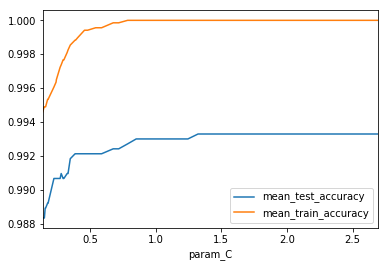

In [99]:
tmp1.plot(x="param_C")

In [100]:
params

{'C': 2.11700001661268}

## Logistic With optimized Hyperparameters 

In [101]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(penalty = 'l2', C=2.11700001661268)
classifier.fit(X_train[all_col], y_train)
score = classifier.score(X_test[all_col], y_test)


print("Train Accuracy %.3f" % classifier.score(X_train[all_col], y_train))
print("Valid Accuracy %.3f" % classifier.score(X_valid[all_col], y_valid))
print("Test Accuracy %.3f" % classifier.score(X_test[all_col], y_test))


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train Accuracy 1.000
Valid Accuracy 0.994
Test Accuracy 0.993


# Model Evaluation Test Data

In [102]:
model = classifier

In [103]:
acc = model.score(X_test[all_col], y_test)

print('Test accuracy:', acc)

Test accuracy: 0.9925373134328358


Confusion matrix, without normalization


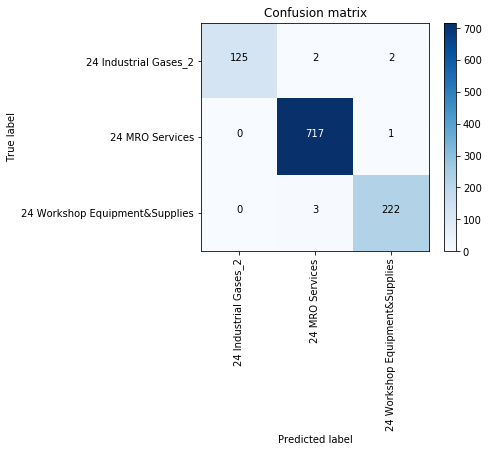

In [104]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = model.predict(X_test[all_col]);
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(['24 Industrial Gases_2','24 MRO Services','24 Workshop Equipment&Supplies']), normalize=False,
                      title='Confusion matrix')

fig.savefig("txt_classification_NN_BOW" + ".png", pad_inches=5.0)


In [105]:
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test, y_pred)
cohen_score

0.9847953506678628

In [106]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred)
text_labels=['24 Industrial Gases','24 MRO Services','24 Workshop Equipment&Supplies']

score_dic= {'Labels':text_labels,
           'precision':precision,
            'recall':recall,
            'fscore':fscore,
            'support':support
           }

pd.DataFrame(score_dic)


,Labels,precision,recall,fscore,support
0,24 Industrial Gases,1.000000,0.968992,0.984252,129
1,24 MRO Services,0.993075,0.998607,0.995833,718
2,24 Workshop Equipment&Supplies,0.986667,0.986667,0.986667,225


In [107]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_test)


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LabelEncoder()

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


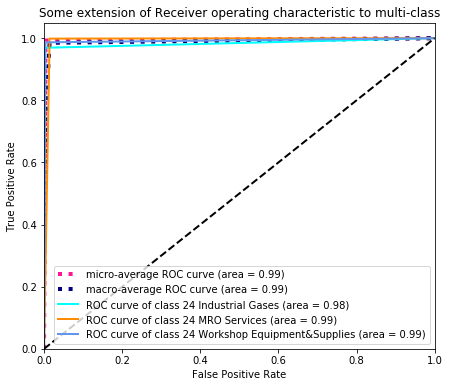

In [108]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from keras.utils import to_categorical

num_labels = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve((y_test==text_labels[i]), (y_pred == text_labels[i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(le.transform(y_test)).ravel(), to_categorical(le.transform(y_pred)).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
# plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(text_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [109]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve((y_test==text_labels[i]), (y_pred == text_labels[i]))
    average_precision[i] = average_precision_score((y_test==text_labels[i]), (y_pred == text_labels[i]))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(to_categorical(le.transform(y_test)).ravel(), to_categorical(le.transform(y_pred)).ravel())
average_precision["micro"] = average_precision_score(to_categorical(le.transform(y_test)), to_categorical(le.transform(y_pred)),
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.99


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.99')

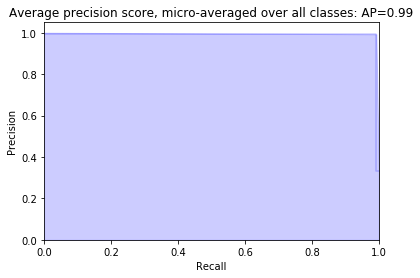

In [110]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

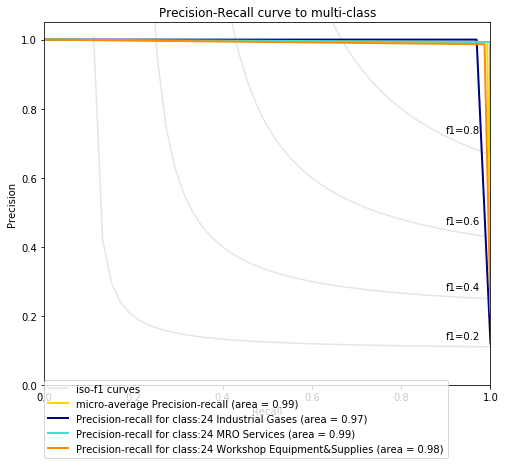

In [111]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(text_labels[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))


plt.show()

# Concatinating All 4 columns before word of bag implementation

In [6]:
df = pd.read_csv(os.getcwd()+r"\Data Files\Corpus_MRO.csv", encoding = 'unicode_escape')

In [7]:
df.head()

,spend_group,spend_cat_sim_l1_nestec,spend_cat_sim_l2_nestec,spend_cat_sim_l3_nestec,material_group_master_data,material_group_master_data_desc,material,material_desc,material_descr_from_po,purchasing_org,...,material_type,material_type_desc,base_unit,account_number,account_number_desc,cost_center,cost_center_desc,invoice_amount,invoice_amt_rep_curr_mth_rate,label_l2
0,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,** Carbagas/Kohlendioxyd CO2 Flüssiggas,CH10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5012160,Energy-CO2,0010/001718102,CO2,"10,400.42 CHF","10,400.42",24 Industrial Gases
1,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,***UMO ALQUILER UNIDAD CRIOGENICA,ES10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5046000,Operating Supplies,0045/794241001,Gastos comunes fábri,"3,574.48 EUR","3,972.83",24 Industrial Gases
2,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,"**19 - CARBON DIOXIDE, COMPLIANCE TRANSP",US10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5046000,Operating Supplies,0076/013893010,Site Supply Chain,"$15,822.53","15,657.73",24 Industrial Gases
3,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,**Bulk CO2 Gas,US10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5014020,Eng. 3rd Part Serv,0042/548919003,TECHNICAL OFFICE,"$1,726.96","1,698.81",24 Industrial Gases
4,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,**CO2 - BULK CARBON DIOXIDE,US10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5046000,Operating Supplies,0042/587817201,REFRIGERATION,"$8,786.90","8,777.23",24 Industrial Gases


In [8]:
df["CONCATED_COLUMN"] = df["material_descr_from_po"]+" "+df["vendor_desc"]+" "+df["account_number_desc"]+" "+df["cost_center_desc"]

In [9]:
x_column = ["material_descr_from_po","vendor_desc","account_number_desc","cost_center_desc","CONCATED_COLUMN"]
y_column = ["label_l2"]
seed = 10

In [10]:
df.label_l2.value_counts()

24 MRO Services                   3566
24 Workshop Equipment&Supplies    1121
24 Industrial Gases                669
Name: label_l2, dtype: int64

In [11]:
X_train_1, X_test, y_train_1, y_test = train_test_split(df[x_column], df[y_column], test_size=0.2, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=seed)

In [12]:
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)
X_valid.reset_index(inplace = True)


In [13]:
print("Train sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_train.shape[0],
                                 round((y_train=="24 MRO Services").sum()/y_train.count()*100,2),
                                 round((y_train=="24 Workshop Equipment&Supplies").sum()/y_train.count()*100,2),
                                 round((y_train=="24 Industrial Gases").sum()/y_train.count()*100,2))
     )

print("valid sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_valid.shape[0],
                                 round((y_valid=="24 MRO Services").sum()/y_valid.count()*100,2),
                                 round((y_valid=="24 Workshop Equipment&Supplies").sum()/y_valid.count()*100,2),
                                 round((y_valid=="24 Industrial Gases").sum()/y_valid.count()*100,2))
     )

print("test sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_test.shape[0],
                                 round((y_test=="24 MRO Services").sum()/y_test.count()*100,2),
                                 round((y_test=="24 Workshop Equipment&Supplies").sum()/y_test.count()*100,2),
                                 round((y_test=="24 Industrial Gases").sum()/y_test.count()*100,2))
     )

Train sample : 3427 	 24 MRO Services : 66.9 	 24 Workshop Equipment&Supplies : 20.8 	Industrial Gases : 12.3
valid sample : 857 	 24 MRO Services : 64.8 	 24 Workshop Equipment&Supplies : 21.6 	Industrial Gases : 13.7
test sample : 1072 	 24 MRO Services : 67.0 	 24 Workshop Equipment&Supplies : 21.0 	Industrial Gases : 12.0


In [14]:
from sklearn.feature_extraction.text import CountVectorizer

selected_col = 'CONCATED_COLUMN'
sentences_train = X_train[selected_col].values
sentences_valid = X_valid[selected_col].values
sentences_test = X_test[selected_col].values

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train1 = vectorizer.transform(sentences_train)
X_valid1 = vectorizer.transform(sentences_valid)
X_test1  = vectorizer.transform(sentences_test)
X_all = vectorizer.transform(df[selected_col].values)

## Logistic Model

## L2 Penalty Hyper Parameter Optimization

In [22]:
param_grid = {'C':np.exp(np.arange(-2,3,0.01))}

In [23]:
from sklearn.model_selection import StratifiedKFold
kfolds = StratifiedKFold(3, random_state=1)
comb=LogisticRegression(penalty = 'l2')

rcv = RandomizedSearchCV(estimator = comb, param_distributions=param_grid, scoring=['accuracy'], n_iter = 50,
    cv=kfolds.split(X_train1,y_train), verbose=0, random_state=1,
    refit = 'accuracy', return_train_score=True, error_score = 0)

In [24]:
#Calculate Gini Lift Logistic Regression
print("Randomized search..")

search_time_start = time.time()
rcv.fit(X_train1, y_train)
print("Randomized search time:", time.time() - search_time_start)
params = rcv.best_params_   #get best parameters
dic=rcv.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

Randomized search..


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Randomized search time: 11.198261976242065


In [25]:
pd.DataFrame(dic).to_csv(r"RCV_results_log_0_l2.csv")

In [26]:
tmp1= pd.DataFrame(dic)[["param_C","mean_test_accuracy","mean_train_accuracy"]].sort_values(by = 'param_C')

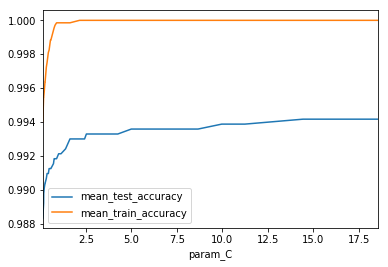

In [27]:
tmp1.plot(x="param_C")

In [28]:
params

{'C': 16.2810198017885}

## Logistic With optimized Hyperparameters 

In [29]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(penalty = 'l2', C=16.2810198017885)
classifier.fit(X_train1, y_train)
score = classifier.score(X_test1, y_test)


print("Train Accuracy %.3f" % classifier.score(X_train1, y_train))
print("Valid Accuracy %.3f" % classifier.score(X_valid1, y_valid))
print("Test Accuracy %.3f" % classifier.score(X_test1, y_test))


Train Accuracy 1.000
Valid Accuracy 0.994
Test Accuracy 0.997


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


# Model Evaluation Test Data

In [30]:
model = classifier

In [31]:
acc = model.score(X_test1, y_test)

print('Test accuracy:', acc)

Test accuracy: 0.9972014925373134


Confusion matrix, without normalization


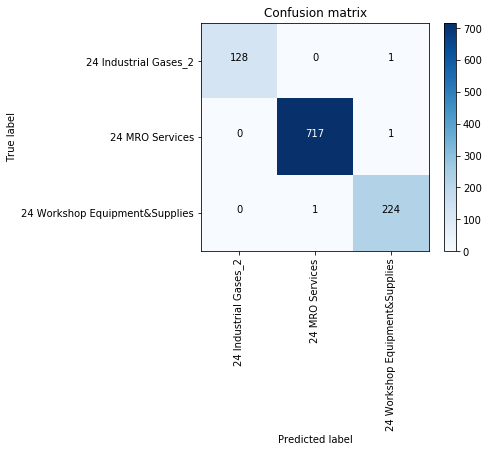

In [32]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = model.predict(X_test1);
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(['24 Industrial Gases_2','24 MRO Services','24 Workshop Equipment&Supplies']), normalize=False,
                      title='Confusion matrix')

fig.savefig("txt_classification_NN_BOW" + ".png", pad_inches=5.0)


In [33]:
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test, y_pred)
cohen_score

0.9943210111990507

In [34]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred)
text_labels=['24 Industrial Gases','24 MRO Services','24 Workshop Equipment&Supplies']

score_dic= {'Labels':text_labels,
           'precision':precision,
            'recall':recall,
            'fscore':fscore,
            'support':support
           }

pd.DataFrame(score_dic)


,Labels,precision,recall,fscore,support
0,24 Industrial Gases,1.000000,0.992248,0.996109,129
1,24 MRO Services,0.998607,0.998607,0.998607,718
2,24 Workshop Equipment&Supplies,0.991150,0.995556,0.993348,225


In [35]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_test)


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LabelEncoder()

Using TensorFlow backend.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


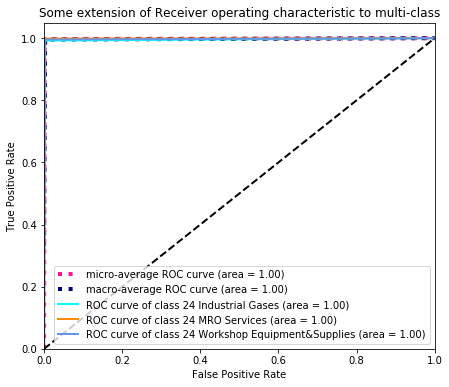

In [36]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from keras.utils import to_categorical

num_labels = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve((y_test==text_labels[i]), (y_pred == text_labels[i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(le.transform(y_test)).ravel(), to_categorical(le.transform(y_pred)).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
# plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(text_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [37]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve((y_test==text_labels[i]), (y_pred == text_labels[i]))
    average_precision[i] = average_precision_score((y_test==text_labels[i]), (y_pred == text_labels[i]))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(to_categorical(le.transform(y_test)).ravel(), to_categorical(le.transform(y_pred)).ravel())
average_precision["micro"] = average_precision_score(to_categorical(le.transform(y_test)), to_categorical(le.transform(y_pred)),
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 1.00


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=1.00')

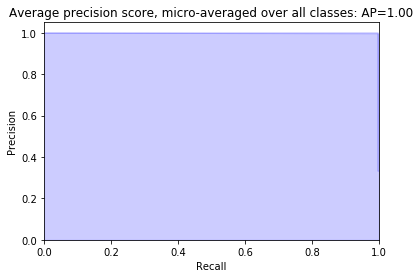

In [38]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

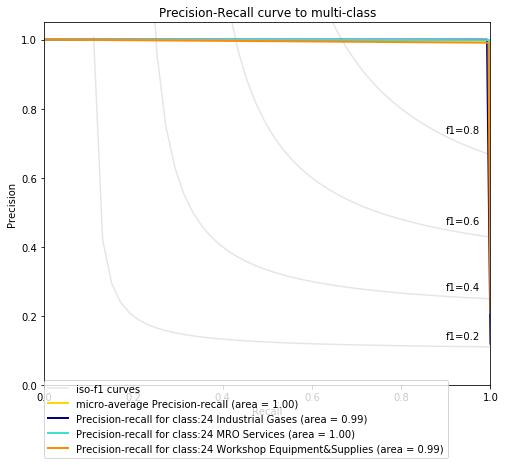

In [39]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(text_labels[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))


plt.show()